In [1]:
!date

Thu May  4 09:23:58 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [3]:
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
#import cv2
from skimage.transform import resize
from datetime import datetime
now = datetime.now

In [4]:
def load_video(fn):
    import skvideo
    import skvideo.io
    videodata = skvideo.io.vread(fn)
    return videodata

In [5]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [6]:
def resize_and_pad_video(video_data):

    target_size = np.array((360, 640))
    input_size = (video_data.shape[1],video_data.shape[2])
    
    d1 = input_size[0]/target_size[0]
    d2 = input_size[1]/target_size[1]

    choose_size = input_size/max(d1,d2)
    choose_size = choose_size.round().astype(int) ## Hacks?

    video_data_resized = np.array([np.array(Image.fromarray(video_data[frame,:,:,:]).resize(choose_size.astype(int)[-1::-1])) for frame in range(video_data.shape[0])])

    assert any(video_data_resized.shape[1:3]==target_size),'neither dimension matches'

    if not video_data_resized.shape[1]==target_size[0]:

        if np.mod(video_data_resized.shape[1],2)==0:
            p = (target_size[0]-video_data_resized.shape[1])/2
            pp = (p.astype(int),p.astype(int))
        else:
            p = (target_size[0]-video_data_resized.shape[1])/2
            p = np.floor(p)
            pp = (p.astype(int),p.astype(int)+1)

        video_data_resized_padded = np.pad(video_data_resized,((0,0),(pp[0],pp[1]),(0,0),(0,0)))
        padding = np.pad(np.ones(video_data_resized.shape),((0,0),(pp[0],pp[1]),(0,0),(0,0)))[0,:,:,0]

    elif not video_data_resized.shape[2]==target_size[1]:

        if np.mod(video_data_resized.shape[2],2)==0:
            p = (target_size[1]-video_data_resized.shape[2])/2
            pp = (p.astype(int),p.astype(int))
        else:
            p = (target_size[1]-video_data_resized.shape[2])/2
            p = np.floor(p)
            pp = (p.astype(int),p.astype(int)+1)

        video_data_resized_padded = np.pad(video_data_resized,((0,0),(0,0),(pp[0],pp[1]),(0,0)))
        padding = np.pad(np.ones(video_data_resized.shape),((0,0),(0,0),(pp[0],pp[1]),(0,0)))[0,:,:,0]

    else:
        video_data_resized_padded = video_data_resized
        padding = np.ones(video_data_resized.shape)[0,:,:,0]

    assert all(video_data_resized_padded.shape[1:3]==target_size), 'failed resizing'
    
    return video_data_resized_padded,padding

In [7]:
categories = os.listdir('./Data/haa500_v1_1_frames/video/')
categories.sort()
print(categories[0:3])
print(categories[-3::])

['ALS_IceBucket_Challenge', 'CPR', 'abseiling']
['yoga_tree', 'yoga_triangle', 'yoga_updog']


In [8]:
calc_or_load = 'load'

if calc_or_load=='load':
    idx_1p = np.load('good_videos_1p_new_4783.npy')
    
elif calc_or_load=='calc':
    
    idx_1p = np.zeros((20,500))
    box_fn = './Data/haa500_v1_1_frames/video/{c}/{c}_{v:03d}/{c}_{v:03d}_{f:03d}_box.npy'
    for c in tqdm(range(500)):
        for v in range(20):
            boxes = [f for f in os.listdir(f'./Data/haa500_v1_1_frames/video/{categories[c]}/{categories[c]}_{v:03d}/') if f.endswith('_box.npy')]
            n = len(boxes)
            idx_1p[v,c] = all([sum(np.load(box_fn.format(c=categories[c],v=v,f=f))[:,-1]==0)==1 for f in range(n)])
    #np.save('good_videos_1p_new_4783.npy',idx_1p)
else:
    print('undefined')

[0. 1.]
4783.0
(20, 500)


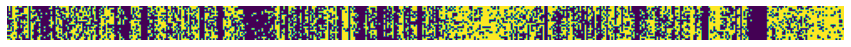

In [9]:
print(np.unique(idx_1p))
print(idx_1p.sum())
print(idx_1p.shape)
plt.figure(figsize=(15,5))
plt.imshow(idx_1p);
plt.axis('off');

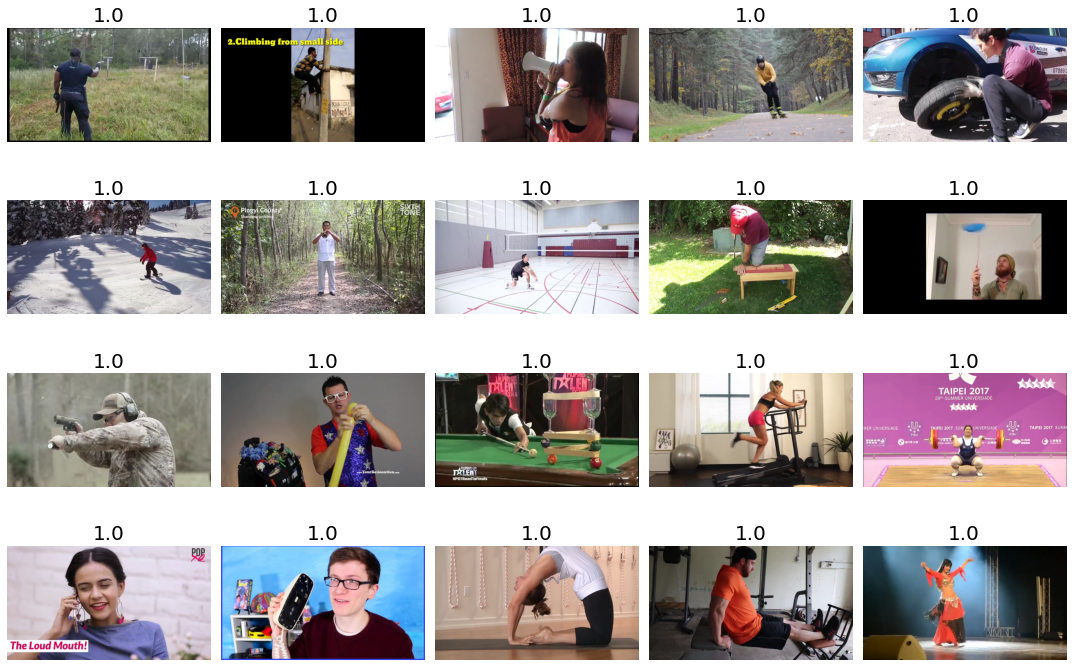

In [10]:
nz = np.nonzero(idx_1p)
plt.figure(figsize=(15,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    r = np.random.randint(low=0,high=len(nz[0]))
    #c = np.random.randint(low=0,high=500)
    #v = np.random.randint(low=0,high=20)
    c = nz[1][r]
    v = nz[0][r]
    f = 0

    im = Image.open('./Data/haa500_v1_1_frames/video/{c}/{c}_{v:03d}/{c}_{v:03d}_{f:03d}.png'.format(c=categories[c],v=v,f=f))
    plt.imshow(np.array(im))
    plt.axis('off')
    plt.title(idx_1p[v,c],fontsize=20)
    
plt.tight_layout()

In [11]:
has_vids = np.zeros((20,500))
for c in tqdm(range(500)):
    for v in range(20):
        fn1 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'.format(c=categories[c],v=v)
        fn2 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_fwd_seg.mp4'.format(c=categories[c],v=v)
        fn3 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_inp_seg.mp4'.format(c=categories[c],v=v)
        has_vids[v,c] = all([os.path.exists(fn) for fn in [fn1,fn2,fn3]])

100%|██████████| 500/500 [00:16<00:00, 31.08it/s]


In [12]:
print(has_vids.sum())
print((has_vids==0).sum())

9371.0
629


In [13]:
good_videos_xl = has_vids.astype(bool)*idx_1p.astype(bool)
good_videos_xl.shape

(20, 500)

In [14]:
print(sum(good_videos_xl.sum(axis=0)>=17))
print(sum(good_videos_xl.sum(axis=0)>=15))
print(sum(good_videos_xl.sum(axis=0)>=10))

60
121
280


In [15]:
minVids = 10

In [16]:
good_videos_xl[:,good_videos_xl.sum(axis=0)<minVids]=0

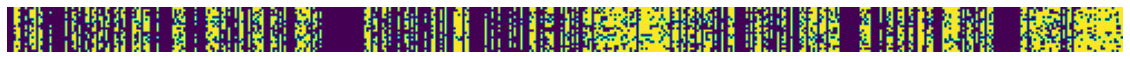

In [17]:
plt.figure(figsize=(20,5))
plt.imshow(good_videos_xl)
plt.axis('off');

In [18]:
good_cats = np.nonzero(good_videos_xl.sum(axis=0)>=minVids)[0]
good_cats_list = list(np.array(categories)[good_cats])
good_vids = [np.nonzero(good_videos_xl[:,good_cat])[0][0:minVids] for good_cat in good_cats]

In [20]:
ng = len(good_cats)
print(ng)

280


In [45]:
# parameters
outdir = './Data/pytorch-data/xl_121_15_action_data_orig'
fn_temp = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_fwd_seg.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_inp_seg.mp4'
#fn_temp = './Data/haa500_v1_1_resized/video/{c}/{c}_{v:03d}.mp4'

In [22]:
## Make/Define Directories
safe_mkdir(outdir)

safe_mkdir(os.path.join(outdir,'train'))
safe_mkdir(os.path.join(outdir,'val'))
safe_mkdir(os.path.join(outdir,'test'))

[safe_mkdir(os.path.join(outdir,'train',category)) for category in good_cats_list];
[safe_mkdir(os.path.join(outdir,'val',category)) for category in good_cats_list];
[safe_mkdir(os.path.join(outdir,'test',category)) for category in good_cats_list];

In [25]:
# Run Main Loop
for c in tqdm(range(ng)):
    for v in range(minVids):              
        fn = fn_temp.format(c=categories[good_cats[c]],v=good_vids[c][v])
        video_data = load_video(fn)
        assert all((video_data.shape[1]==360,video_data.shape[2]==640)),f'bad size dumbass: {video_data.shape}'
        
        nframes = video_data.shape[0]
        video_data = resize(np.pad(video_data,((0,0),(140,140),(0,0),(0,0))),(nframes,224,224,3)) # resize to 244*244 (0-1 range)
        video_data = (video_data*255).astype(np.uint8) # make into 0-255 uint
              
        if v==0:
            outdir_subfolder = os.path.join(outdir,'val',categories[good_cats[c]])
        elif v==1:
            outdir_subfolder = os.path.join(outdir,'test',categories[good_cats[c]])
        else:
            outdir_subfolder = os.path.join(outdir,'train',categories[good_cats[c]])

        [Image.fromarray(video_data[f,:,:,:]).save(os.path.join(outdir_subfolder,f'{good_vids[c][v]:03d}_{f:03d}.jpg')) for f in range(nframes)];

 52%|███████████████████▎                 | 63/121 [3:04:18<2:49:40, 175.53s/it]


KeyboardInterrupt: 